# PV Performance Model Validation
The purpose of this notebook is to validate the use of new or current PV performance models through multiple steps of analysis

<li><b>1. Import data from DuraMAT</b></li>
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx
<li><b>2. Define relevant system & meteo data</b></li>
<li><b>3. Run model to be validated or import model results</b></li>
<li><b>4. Compare model to measured results and other baseline models</b></li>

In [1]:
#import necessary packages and set default formatting for plots
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import pvlib
import pvanalytics
import sklearn.metrics
import scipy
from matplotlib.lines import Line2D 
from tabulate import tabulate

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

## 1. Import data

In [2]:
#read in data from duramat datahub directly
df = pd.read_excel('pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx', sheet_name='S2')
#df = pd.read_excel(https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/b54bdc36-1864-48a9-abab-daf0e3f8dcf5/download/pvpmc_2021_blind_modeling_comparison_data_s1-s6.xlsx,
#                   sheet_name='S2'

#Reassigning the index so the timesteps are at the middle of the hour
df.index = pd.date_range(start='2021-01-01 00:30:00', end='2021-12-31 23:30:00', freq='H')
df.index = df.index.tz_localize('MST')

#apply the filters that are included in the data & replacing any 0 with nan so they dont affect error metrics
#dropping nans helps keep size down so operations run more quickly and smoothly
df = df.where((df['bsrn_pass'] == 1) & (df['SNL No Snow'] == 1) & (df['Measured DC power (W)'] > 1)).dropna()
df.replace(0, np.nan, inplace=True)
df.dropna(inplace=True)

df.head()

,Scenario,Year,Month,Day,Hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Ambient Temp (°C),Relative Humidity (%),Wind Speed (m/s),Measured front POA irradiance (W/m2),Measured module temperature (°C),Measured DC power (W),bsrn_pass,SNL No Snow
2021-01-01 08:30:00-07:00,S2,2020.0,1.0,1.0,9.0,185.738601,754.498236,31.546335,-3.652383,54.784333,1.803700,442.132104,6.645174,1292.814741,1.0,1.0
2021-01-01 09:30:00-07:00,S2,2020.0,1.0,1.0,10.0,353.666975,914.471581,40.138926,-0.708700,41.447333,2.923567,701.031595,17.712519,2276.603041,1.0,1.0
2021-01-01 10:30:00-07:00,S2,2020.0,1.0,1.0,11.0,482.624408,978.551782,44.586906,0.819633,38.089500,2.962067,879.164182,25.669461,2782.780150,1.0,1.0
2021-01-01 11:30:00-07:00,S2,2020.0,1.0,1.0,12.0,555.822941,1006.709614,44.024464,2.140700,36.223167,1.919817,977.788429,35.226433,2989.486270,1.0,1.0
2021-01-01 12:30:00-07:00,S2,2020.0,1.0,1.0,13.0,546.147743,865.317214,98.340036,3.236667,35.082167,1.641850,922.354253,38.056121,2796.495393,1.0,1.0


## 2. Define system and meteo data

pan file \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/a3862674-3a50-4b28-817d-4885ce5f551d/download/pan-canadian-solar_cs6k-275m_dec2019_cfv.pan_.txt

iec matrix \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/4f36a75e-8afb-40e9-b9c3-ed2e562a2a45/download/iec61853-1_sandia_pv_module_p-matrix-and-tempco-data_2019.xlsx

test reports \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/6bf975f3-1134-4a2f-82f3-a56b25e97f36/download/pan-file-report-canadian-solar-cs6k-275m.pdf \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/22b38afc-2625-4005-8b42-70c4a1b4a9ca/download/test-report-iamnmot-canadian-solar-cs6k-275m.pdf

spec sheet \
https://datahub.duramat.org/dataset/293db0cb-e838-4f7a-8e77-f62e85328c47/resource/a2cb566b-2227-46e3-8768-61d1d21df456/download/specsheet_cs_cs6k-275m.pdf

Solar position & Irradiance components

In [3]:
#Defining system constants 
module = {'Tilt': 35,'Latitude': 35.05,'Longitude': -106.54,'Altitude': 1600,'Surface Azimuth': 180,'String Length':12, 'iam0':1,'iam10': 0.9989, 'iam20': 1.0014, 'iam30': 1.0002, 'iam40':0.9984, 
          'iam45': 0.9941, 'iam50': 0.9911, 'iam55': 0.9815, 'iam60':0.9631, 'iam65':0.9352, 'iam70':0.8922, 'iam75':0.8134, 'iam80':0.6778, 'iam85': 0.4351,
         'U0': 28.825, 'U1': 4.452, 'NOCT': 45, 'Unit Mass': 11.119, 'Area':1.621, 'Pmp' : 275, 'Gamma Pmp': -0.0041, 'Alpha Isc':0.0033,
          'Beta Voc': -0.1178, 'Cell Type':'monoSi', 'Cells in Series':60}
module = pd.Series(module)

#read in iec 61853-1 testing matrix
iec61853 = pd.read_excel('iec61853-1_sandia_pv_module_p-matrix-and-tempco-data_2019.xlsx', sheet_name='19074-005 (CS6K-275M)', header=4)
iec61853_stc = iec61853.loc[(iec61853['Temperature [Â°C]'] == 25) & (iec61853['Irradiance [W/m2]']==1000)]
dataCan = {'Irradiance': [100, 200, 400, 600, 800, 1000, 1100], 'Relative Efficiency': [0.923314066, 0.957349138,0.981810786,0.993869356,0.997680967,1,0.99875193]}
efficiency = pd.DataFrame(dataCan)

#Running solar position calculations
#Calculate Solar Positions & Extraterrestrial DNI

spdf = pvlib.solarposition.get_solarposition(time=df.index, latitude=module['Latitude'], 
        longitude=module['Longitude'],temperature=df['Ambient Temp (°C) '], altitude=module['Altitude'])
spdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=df.index)
pres = pvlib.atmosphere.alt2pres(module['Altitude'])

#Save these values into the df with inputs & results for use in later analysis
df['Azimuth'] = spdf['azimuth']
df['Zenith'] = spdf['apparent_zenith']
df['Sol Elev'] = spdf['elevation']
df['Clearness Index'] = pvlib.irradiance.clearness_index(ghi=df['GHI (W/m2)'], solar_zenith=spdf['apparent_zenith'], extra_radiation = spdf['dni_extra'])
spdf.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time,dni_extra
2021-01-01 08:30:00-07:00,77.884310,77.950122,12.115690,12.049878,129.546848,-3.734135,1413.981805
2021-01-01 09:30:00-07:00,69.241432,69.279260,20.758568,20.720740,140.756151,-3.753597,1413.981805
2021-01-01 10:30:00-07:00,62.615700,62.643406,27.384300,27.356594,154.026282,-3.773049,1413.981805
2021-01-01 11:30:00-07:00,58.731118,58.754688,31.268882,31.245312,169.230769,-3.792492,1413.981805
2021-01-01 12:30:00-07:00,58.153100,58.176057,31.846900,31.823943,185.427677,-3.811925,1413.981805


In [4]:
#Calculate Environmental Conditions

edf = pvlib.irradiance.get_total_irradiance(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'],dni=df['DNI (W/m2)'],
        ghi=df['GHI (W/m2)'], dhi=df['DHI (W/m2)'], dni_extra=spdf['dni_extra'], model ='perez', model_perez='albuquerque1988')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=module['Tilt'], surface_azimuth=module['Surface Azimuth'], 
        solar_zenith=spdf['apparent_zenith'], solar_azimuth=spdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=spdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pres)
df['AOI'] = edf['aoi']

In [5]:
#Calculate Effective Irradiance

ref_thetas= [0,10,20,30,40,45,50,55,60,65,70,75,80,85]
ref_iams = [module['iam0'],module['iam10'],module['iam20'],module['iam30'],module['iam40'],module['iam45'],module['iam50'],
            module['iam55'],module['iam60'],module['iam65'],module['iam70'],module['iam75'],module['iam80'],module['iam85']]
F2 = pvlib.iam.interp(aoi=edf['aoi'],theta_ref=ref_thetas,iam_ref=ref_iams )
df['Effective Irradiance'] = (edf['poa_direct'] * F2 + edf['poa_diffuse'])
df['IAMs'] = F2

In [6]:
#Converting our measured module temperature to cell temperature for use in the models that require cell temp

tmp = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
df['Cell Temperature'] = pvlib.temperature.sapm_cell_from_module(module_temperature=df['Measured module temperature (°C)'], 
                                                                 poa_global=df['Measured front POA irradiance (W/m2)'], deltaT = tmp['deltaT'] )                  

## 3. Run the model or import results to be validated

In [7]:

#run model here
cec_params = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['Cell Type'], v_mp=iec61853_stc['Vmp [V]'], i_mp=iec61853_stc['Imp [A]'], v_oc=iec61853_stc['Voc [V]'], i_sc=iec61853_stc['Isc [A]'], 
                              alpha_sc=module['Alpha Isc'], beta_voc=module['Beta Voc'], gamma_pmp=module['Gamma Pmp']*100, cells_in_series=module['Cells in Series'], temp_ref=25)

cec_sdm = pvlib.pvsystem.calcparams_cec(effective_irradiance=df['Effective Irradiance'], temp_cell=df['Cell Temperature'], alpha_sc=module['Alpha Isc'], 
                              I_L_ref=cec_params[0], I_o_ref=cec_params[1],R_s=cec_params[2], R_sh_ref=cec_params[3],  a_ref=cec_params[4],Adjust=cec_params[5])

df['Modeled DC power'] = (pvlib.pvsystem.singlediode(photocurrent = cec_sdm[0], saturation_current = cec_sdm[1],resistance_series =cec_sdm[2], resistance_shunt = cec_sdm[3], 
                                                     nNsVth = cec_sdm[4], method = 'newton')['p_mp']*module['String Length'])

# or import model results here. Make sure timestamps line up and are middle-of-hour
# df['Modeled DC power'] = pd.read_excel('results.xlsx')

#Either run a model in this notebook or import the results into the column name below
model_name = 'CEC'

### Visualize the results of the model over a sample day 
This preliminary check helps make sure the results are feasible and there aren't any obvious errors like time shifts or magnitude differences

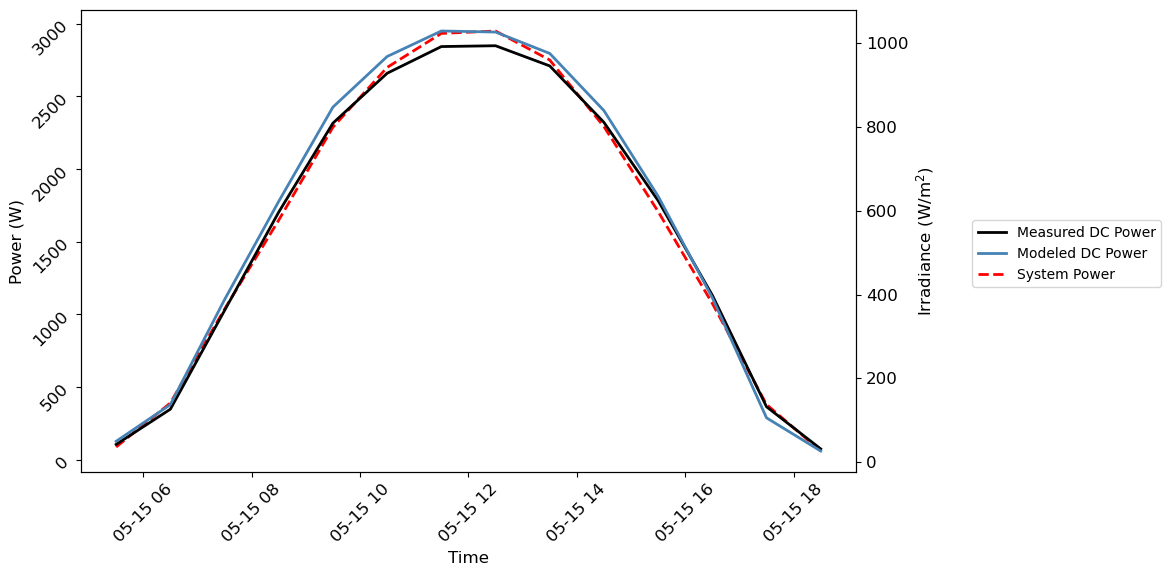

In [8]:
#diurnal plot
day = 15
month = 5

fig, ax = plt.subplots()
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured DC power (W)'], linewidth=2, color='black', zorder=5.5)
ax.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'], linewidth=2, color='steelblue', zorder=5.5)

ax.tick_params(labelrotation = 45)
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured front POA irradiance (W/m2)'], linewidth=2,linestyle='dashed',color='red',zorder=2.5)
ax2.set_ylabel('Irradiance (W/m$^2$)')
plt.grid(False)
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

line_1 = Line2D([0], [0], color='black', linewidth=2, linestyle='-',label='Measured DC Power')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Modeled DC Power')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='System Power')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.15, 0.4],handles=lines)

## 4. Compare modeled values to measured values + other baseline models

### 3 steps of analysis:
<li><b>1. Overall NMBE, MBE, RMSE, NRMSE, and other errors of the model</b></li>
<li><b>2. Residual analysis</b></li>
<li><b>3. Comparison to baseline model</b></li>

### Analysis I: Overall errors of the model
#### • Normalized Bias Error (NBE) - shows the estimation bias of the model
###                  $100 * \frac{V_{modeled} - V_{measured}}{V_{measured}}$


#### • Root Mean Squared Error (RMSE) - measures average difference between modeled and measured values
### $ \sqrt{\frac{1}{N} \sum_{i=1}^{N}(V_{modeled}-V_{measured})^2} $

In [9]:
df['NBE'] = 100 * (df['Modeled DC power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])
nmbe = df['NBE'].mean()
df['BE'] = (df['Modeled DC power'] - df['Measured DC power (W)'])
mbe = df['BE'].mean()
rmse = sklearn.metrics.mean_squared_error(df.dropna()['Modeled DC power'],df.dropna()['Measured DC power (W)'], squared=False)
nrmse = 100 * rmse/(df['Measured DC power (W)'].mean())
#print these in a neat table 
d = [['NMBE', str(round(nmbe,3))+' %'], ['MBE', str(round(mbe,3))+' W'], ['NRMSE', str(round(nrmse,3))+' %'], ['RMSE',str(round(rmse,3))+' W']]
print (tabulate(d, headers=["Metric", "Value"]))

Metric    Value
--------  ---------
NMBE      4.627 %
MBE       70.699 W
NRMSE     6.019 %
RMSE      101.159 W


Text(0.5, 1.0, 'Measured vs Modeled Values')

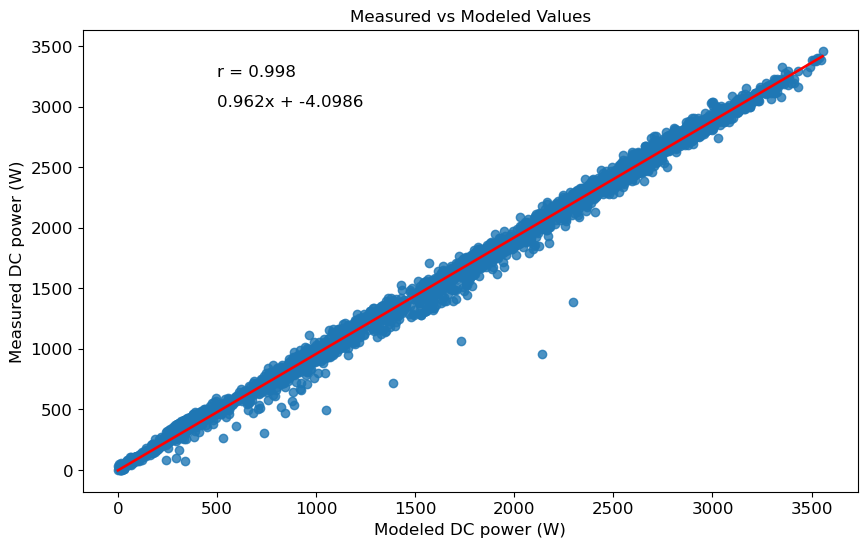

In [10]:
slope, intercept, r, p, std = scipy.stats.linregress(x = df.dropna()['Modeled DC power'], y = df.dropna()['Measured DC power (W)'])
sns.regplot(x = df['Modeled DC power'], y = df['Measured DC power (W)'], line_kws={'color':'red'})

plt.ylabel('Measured DC power (W)')
plt.xlabel('Modeled DC power (W)')
plt.text(500, 3250, s = ("r = "+str(round(r,4))))
plt.text(500, 3000, s = (str(round(slope,4))+'x + '+str(round(intercept,4))))
plt.title('Measured vs Modeled Values')

#The plot should be mostly linear. r and slope values close to one indicate good correlation and accurate model performance

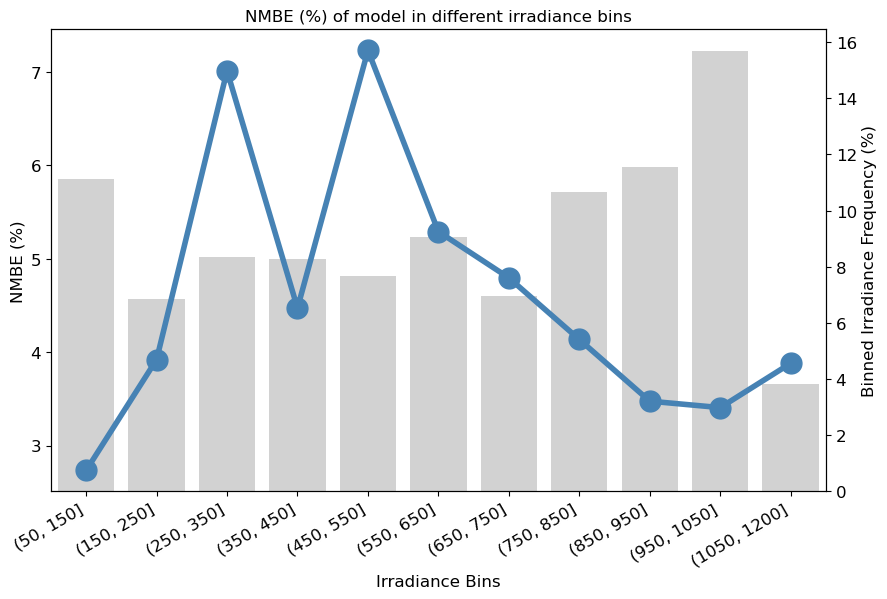

In [11]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels
df['Irradiance Bins']=(pd.cut(x=df['Measured front POA irradiance (W/m2)'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean().sort_values('Irradiance Bins')['NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=4, markersize=15)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('NMBE (%) of model in different irradiance bins')
plt.show()


Text(0.5, 1.0, 'NMBE (%) of the model by month')

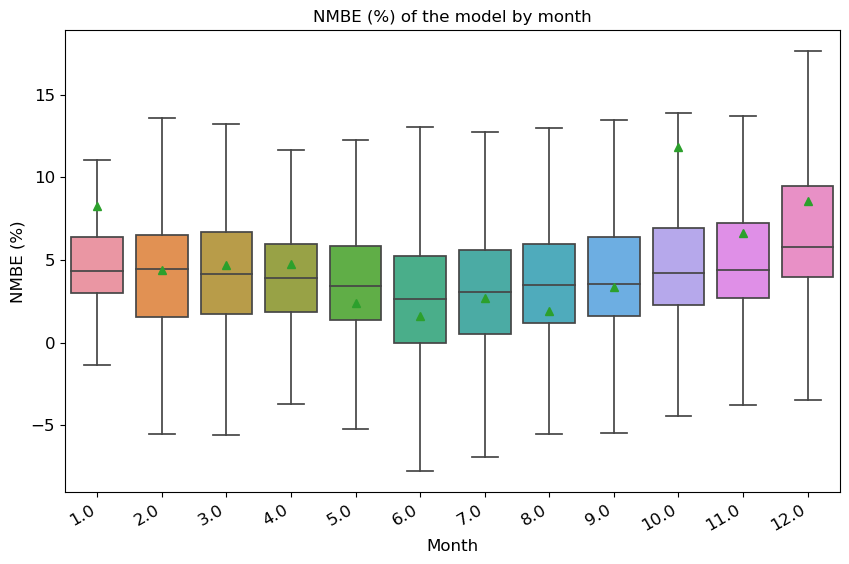

In [12]:
#nmbe by month
sns.boxplot(data=df, x='Month', y='NBE', showfliers=False, showmeans=True)
plt.xticks(rotation=30, ha='right')
plt.ylabel('NMBE (%)')
plt.title('NMBE (%) of the model by month')

### Analemma Plots
These are another way to check seasonality of a model and can also show how the model performs at specific times of day

Text(0.5, 0, 'Solar Azimuth')

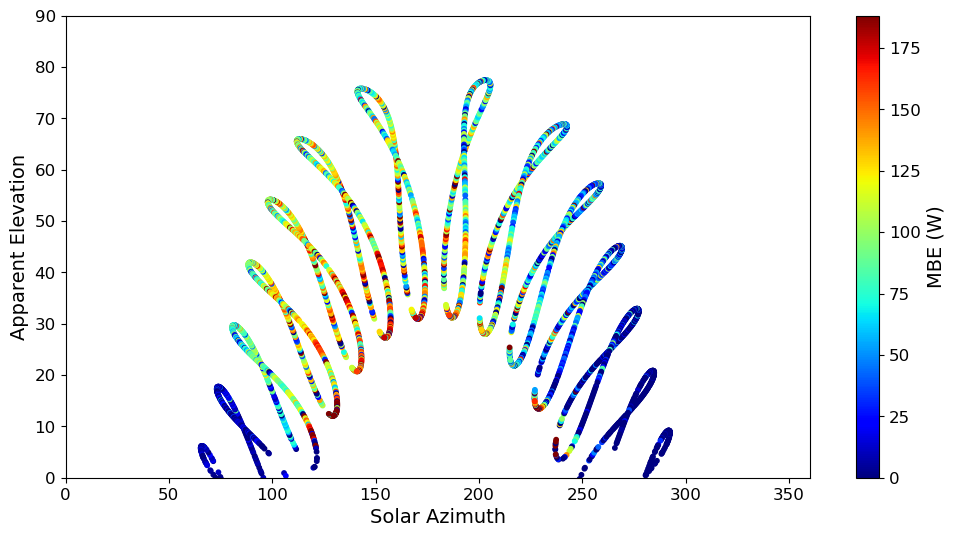

In [13]:
#analemma plots show the residuals at different times of the day/year
plt.figure(figsize=(12,6))
plt.scatter(x=df['Azimuth'], y=df['Sol Elev'], c=df['BE'], cmap='jet', s=10)
clb = plt.colorbar()
clb.ax.set_ylabel('MBE (W)',fontsize =14)
plt.clim(0,(df['BE'].describe()['75%'] + df['BE'].describe()['std']))
plt.xlim(0,360)
plt.ylim(0,90)
plt.ylabel('Apparent Elevation', fontsize=14 )
plt.xlabel('Solar Azimuth',fontsize =14)

### Energy Yield Estimates
We can compare the energy yield estimate to the measured value to see what the difference is on an annual scale

In [14]:
#find overall % diff for annual energy
print('The measured annual energy is', round(df['Measured DC power (W)'].sum()/1000,3),
      'kWh and the predicted annual energy using the model is', round(df['Modeled DC power'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate from measured to modeled is ', 
      round(((df['Modeled DC power'].sum()-df['Measured DC power (W)'].sum())/df['Measured DC power (W)'].sum())*100,3),'%')

The measured annual energy is 6478.433 kWh and the predicted annual energy using the model is 6750.977 kWh
The % difference in energy estimate from measured to modeled is  4.207 %


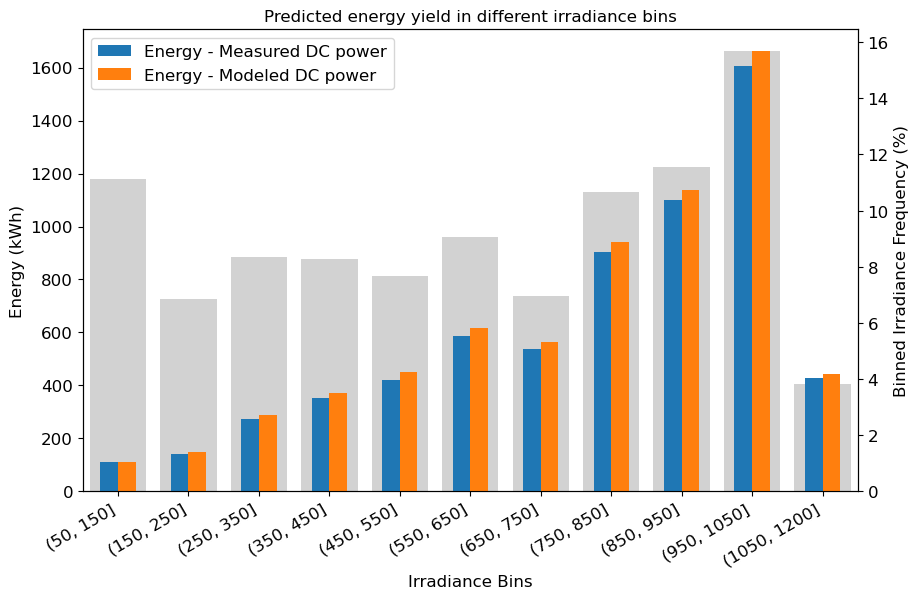

In [15]:
#we can plot the energy produced in each bin of irradiance and see where the largest differences are 

bins['Energy - Modeled DC power'] = df.groupby('Irradiance Bins').sum()['Modeled DC power']/1000
bins['Energy - Measured DC power'] = df.groupby('Irradiance Bins').sum()['Measured DC power (W)']/1000
bins = bins.sort_values('Irradiance Bins')

ax = bins.plot(x="Irradiance Bins", y=["Energy - Measured DC power", "Energy - Modeled DC power"], kind="bar", rot=0)
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Energy (kWh)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plt.title('Predicted energy yield in different irradiance bins')
plt.show()


### Analysis II: Residual Analysis
#### • Residual Analysis - quantifies the degree that variables may affect model errors
### $V_{modeled} - V_{measured}$

### Residual Distribution
Residuals should be normally distributed, otherwise this indicates a consistent bias of over or under predicting \
To get a closer look at a majority of the residuals, the outer 1% are removed using z-score. The distribution should be centered about the mean, shown by the red line

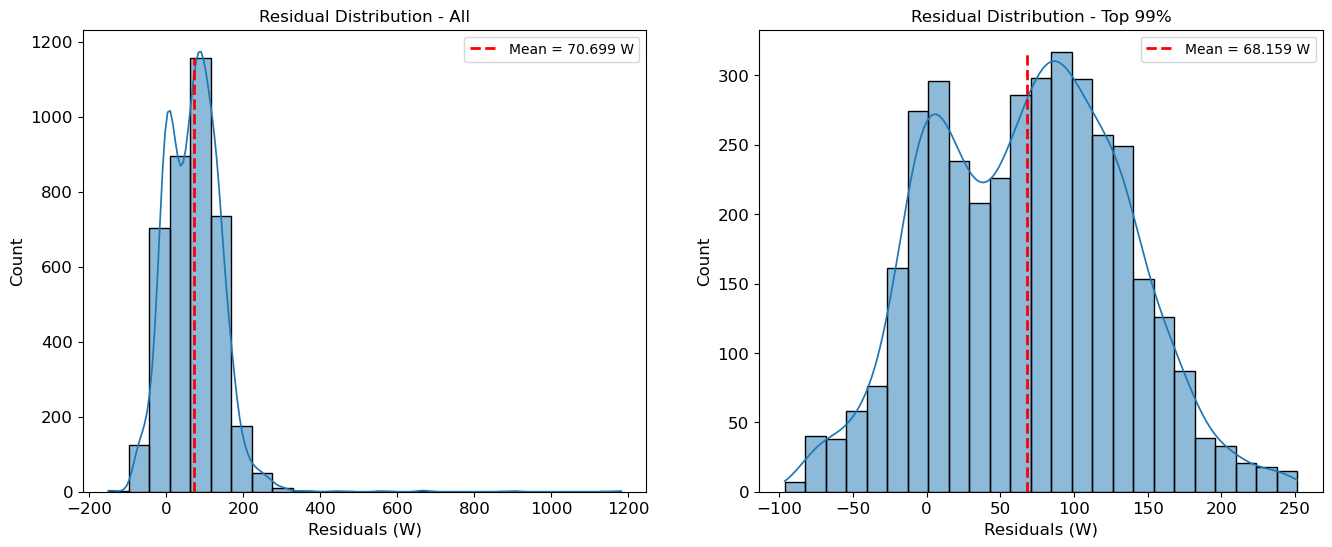

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

df['Residuals'] = df['Modeled DC power'] - df['Measured DC power (W)']
hsp = sns.histplot(df['Residuals'], kde=True, bins=25, ax=ax1)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax1.vlines(x=df['Residuals'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax1.set_title('Residual Distribution - All')
ax1.set_xlabel('Residuals (W)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['Residuals'].mean(),3))+' W'))]
ax1.legend(prop=dict(size='small'),handles=line_4)

#Use z-score to eliminate the outer 1% of residuals
df['zscore'] = scipy.stats.zscore(df['Residuals'].dropna())
df['resid_trim'] = df['Residuals'][(df['zscore'] < 2.5) & (df['zscore'] > -2.5)]
hsp = sns.histplot(df['resid_trim'], kde=True, bins=25, ax=ax2)
h = []
for rectangle in hsp.patches:
    h.append(rectangle.get_height())
ax2.vlines(x=df['resid_trim'].mean(), ymin=0, ymax=max(h), linewidth=2, color='red',linestyles='--')
ax2.set_title('Residual Distribution - Top 99%')
ax2.set_xlabel('Residuals (W)')
line_4 = [Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('Mean ='+' '+str(round(df['resid_trim'].mean(),3))+' W'))]
ax2.legend(prop=dict(size='small'),handles=line_4)

Text(764.6928104575164, 0.5, 'Model Residuals (W)')

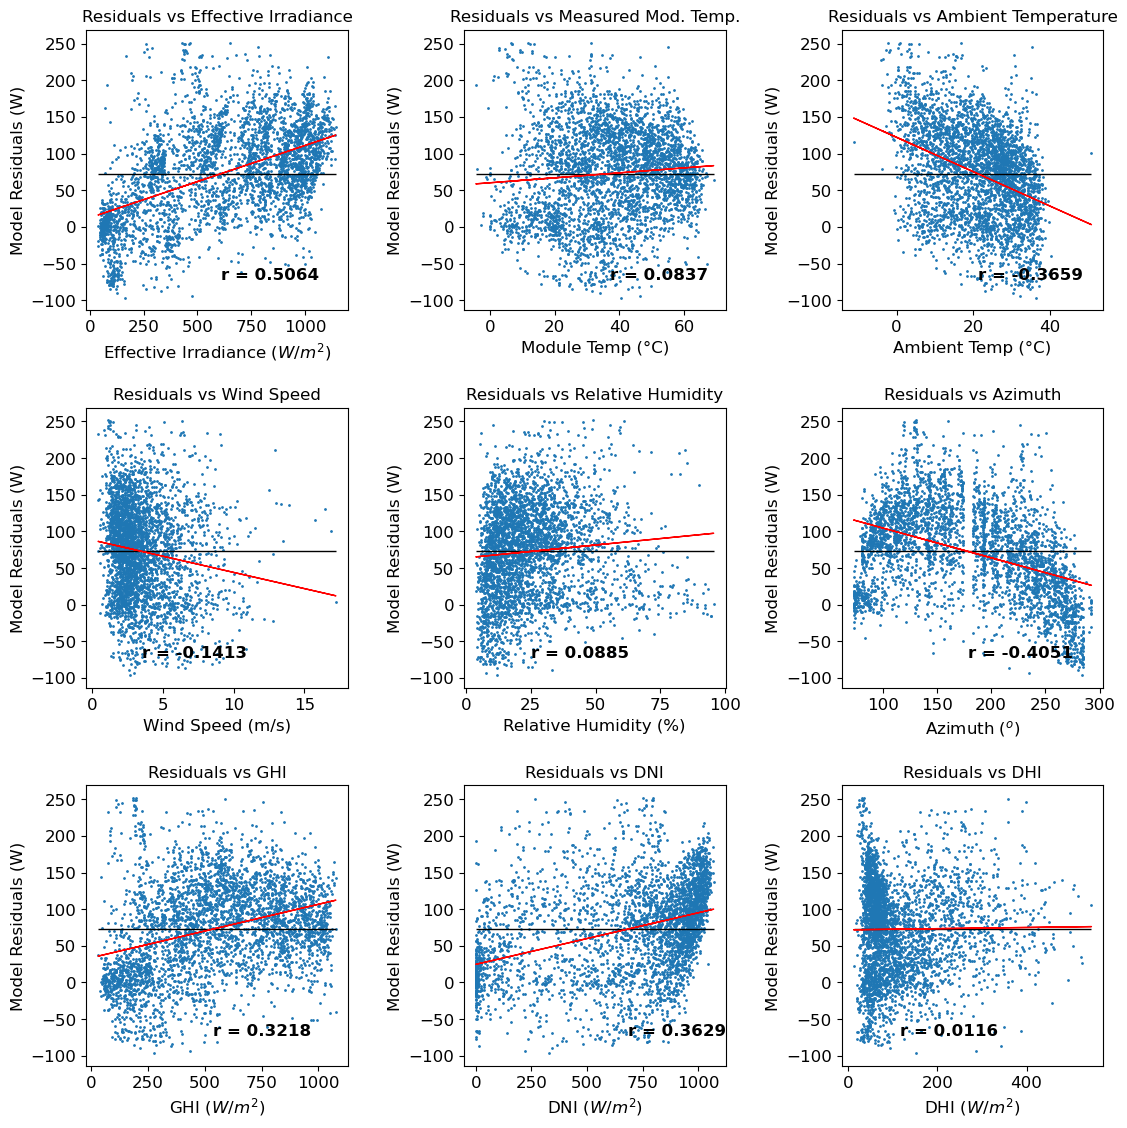

In [17]:
fig, axs = plt.subplots(3, 3,figsize=(12,12))
fig.tight_layout(pad=4.0)
# y = df['Residuals']
# y_avg = df['Residuals'].mean()
# y_med = df['Residuals'].median()
df = df.dropna()
y = df['resid_trim']
y_avg =  df['resid_trim'].mean()
y_med =  df['resid_trim'].median()

x = df['Effective Irradiance']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 0].scatter(x, y, s=1)
axs[0, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 0].plot(x, p(x), linewidth=1, color='red')
axs[0, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 0].set_title('Residuals vs Effective Irradiance')
axs[0, 0].set_xlabel('Effective Irradiance ($W/m^2$)')
axs[0, 0].set_ylabel('Model Residuals (W)')
x = df['Measured module temperature (°C)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 1].scatter(x, y, s=1)
axs[0, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 1].plot(x, p(x), linewidth=1, color='red')
axs[0, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 1].set_title('Residuals vs Measured Mod. Temp.')
axs[0, 1].set_xlabel('Module Temp (°C)')
axs[0, 1].set_ylabel('Model Residuals (W)')
x = df['Ambient Temp (°C) ']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[0, 2].scatter(x, y, s=1)
axs[0, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[0, 2].plot(x, p(x), linewidth=1, color='red')
axs[0, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[0, 2].set_title('Residuals vs Ambient Temperature')
axs[0, 2].set_xlabel('Ambient Temp (°C)')
axs[0, 2].set_ylabel('Model Residuals (W)')
x = df['Wind Speed (m/s)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 0].scatter(x, y, s=1)
axs[1, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 0].plot(x, p(x), linewidth=1, color='red')
axs[1, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 0].set_title('Residuals vs Wind Speed')
axs[1, 0].set_xlabel('Wind Speed (m/s)')
axs[1, 0].set_ylabel('Model Residuals (W)')
x = df['Relative Humidity (%)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 1].scatter(x, y, s=1)
axs[1, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 1].plot(x, p(x), linewidth=1, color='red')
axs[1, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 1].set_title('Residuals vs Relative Humidity')
axs[1, 1].set_xlabel('Relative Humidity (%)')
axs[1, 1].set_ylabel('Model Residuals (W)')
x = df['Azimuth']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[1, 2].scatter(x, y, s=1)
axs[1, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[1, 2].plot(x, p(x), linewidth=1, color='red')
axs[1, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[1, 2].set_title('Residuals vs Azimuth')
axs[1, 2].set_xlabel('Azimuth ($^o$)')
axs[1, 2].set_ylabel('Model Residuals (W)')
x = df['GHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 0].scatter(x, y, s=1)
axs[2, 0].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 0].plot(x, p(x), linewidth=1, color='red')
axs[2, 0].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[2, 0].set_title('Residuals vs GHI')
axs[2, 0].set_xlabel('GHI ($W/m^2$)')
axs[2, 0].set_ylabel('Model Residuals (W)')
x = df['DNI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 1].scatter(x, y, s=1)
axs[2, 1].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 1].plot(x, p(x), linewidth=1, color='red')
axs[2, 1].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[2, 1].set_title('Residuals vs DNI')
axs[2, 1].set_xlabel('DNI ($W/m^2$)')
axs[2, 1].set_ylabel('Model Residuals (W)')
x = df['DHI (W/m2)']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
r = np.corrcoef(x,y)[0][1]
axs[2, 2].scatter(x, y, s=1)
axs[2, 2].hlines(y=y_avg, xmin=x.min(), xmax=x.max(), linewidth=1, color='black',linestyles='-')
axs[2, 2].plot(x, p(x), linewidth=1, color='red')
axs[2, 2].text(x = x.mean(), y=(y.min() + (-0.25*y.min())), s=( "r = "+str(round(r,4))), weight='bold')
axs[2, 2].set_title('Residuals vs DHI')
axs[2, 2].set_xlabel('DHI ($W/m^2$)')
axs[2, 2].set_ylabel('Model Residuals (W)')


### Residuals by month
Grouping the residuals by month is one way to check if the model has any extreme behavior in specific seasons of the year \
This is done below with a boxplot which shows the spread of the data within the months and a jointplot which can show this and the distribution of the data across the months as well

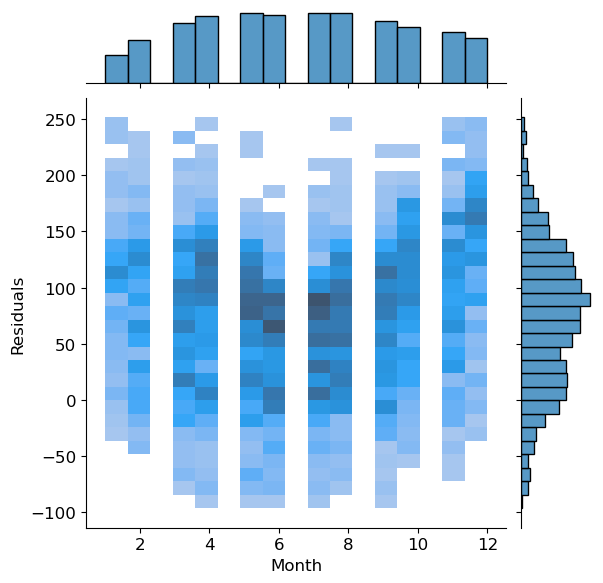

In [18]:
sns.jointplot(data=df, x='Month', y='Residuals', kind='hist')#, space=0, marginal_ticks=True)

### Empirical Cumulative Distribution Plot (ECDF)
This plot shows the cumulative distribution of the residuals with the median as the dashed line and the mean as the solid line

Text(0.5, 1.0, 'ECDF of Model Residuals - Top 99%')

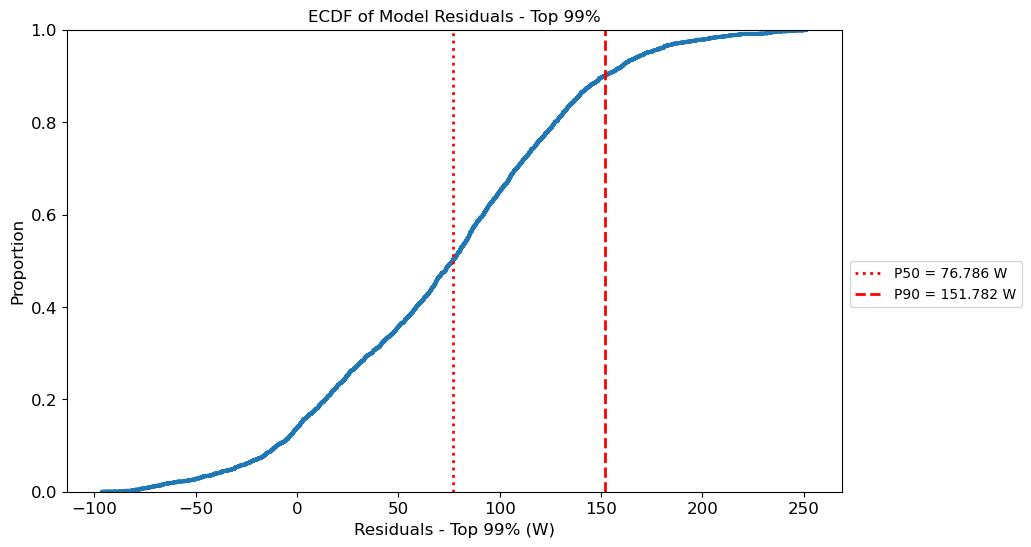

In [19]:
#plot empirical cumulative distribution functions
sns.ecdfplot(data=df, x='resid_trim', linewidth=3)
plt.xlabel('Residuals - Top 99% (W)')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='red',linestyles='dotted')
plt.vlines(x=np.percentile(df['resid_trim'].dropna(), 90), ymin=0, ymax=1, linewidth=2, color='red',linestyles='--')
line_2 = Line2D([0], [0], color='red', linewidth=2, linestyle='dotted',label=('P50 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 50),3))+' W'))
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label=('P90 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 90),3))+' W'))
lines = [line_2,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model Residuals - Top 99%')

### Relative Efficiency

####  Calculate the temperature corrected efficiency:
##  $\eta_{@ 25°C} = \frac{Power * (1 + \gamma*(25°C - T_{Module}))}{POA * Area}$

#### Then calculate the nominal efficiency by taking the median efficiency using measured module performance when irradiance is ~1000 $W/m^2$ and AOI < 70°
##### The range around 1000 $W/m^2$ can vary based on location and annual irradiance values

In [20]:
#temperature corrected efficiency
df['Eff at 25C'] = df['Modeled DC power'] * (1 + (module['Gamma Pmp'] * (25 - (df['Measured module temperature (°C)']))))/(df['Measured front POA irradiance (W/m2)'] * module['Area'])

In [21]:
#determining nominal efficiency
#we take a window around 1000 w/m2
low_lim = 950
upp_lim = 1050
aoi_lim = 70
df_eff = df.loc[(df['Effective Irradiance'] > low_lim) & (df['Effective Irradiance'] > upp_lim) & (df['AOI'] < aoi_lim)]
eff_nom = ((df_eff['Modeled DC power'] * (1 + (-0.0041 * (25 - (df['Measured module temperature (°C)'])))))/(df_eff['Measured front POA irradiance (W/m2)'] * module['Area'])).median()

In [22]:
df['Relative Efficiency'] = df['Eff at 25C']/eff_nom

(0.6, 1.3)

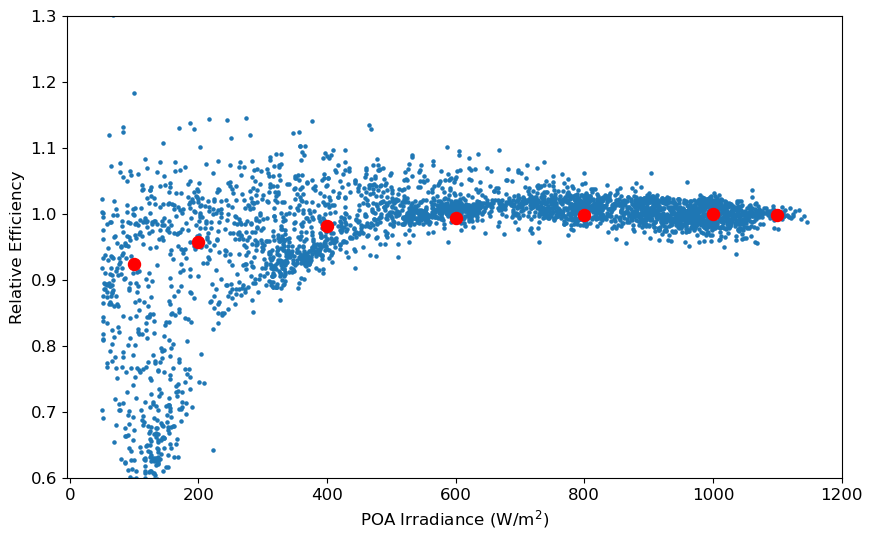

In [23]:
plt.scatter(df['Measured front POA irradiance (W/m2)'],df['Relative Efficiency'], s=5)
plt.scatter(efficiency['Irradiance'], efficiency['Relative Efficiency'], s=75, c='red')
plt.ylabel('Relative Efficiency')
plt.xlabel('POA Irradiance (W/m$^2$)')
plt.ylim(0.6,1.3)

Text(0.5, 1.0, 'ECDF of Model at High and Low Clearness Index levels')

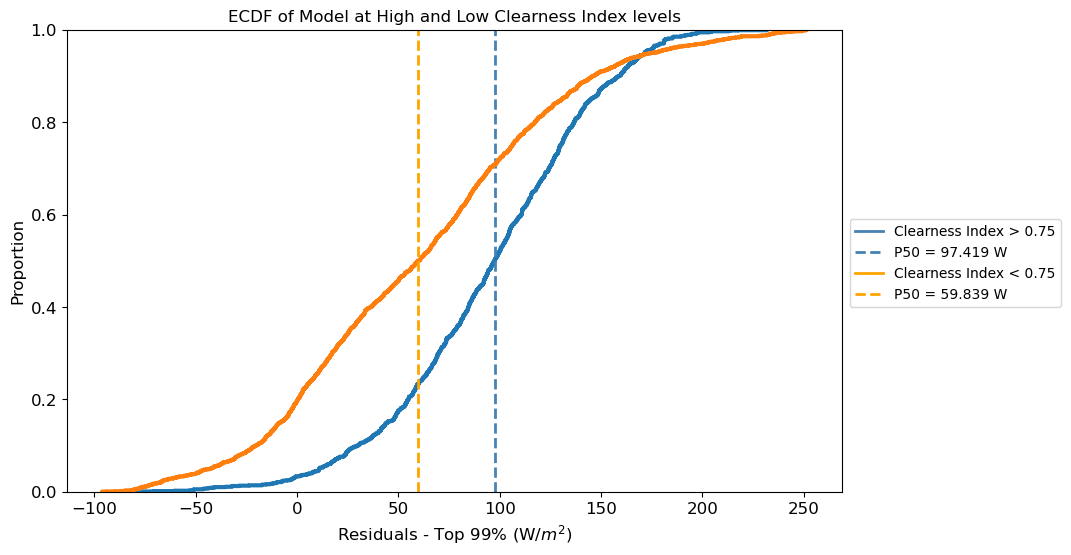

In [24]:
#plotting the ecdf of two groups, determined by the specified metric & boundary
#metric must be a column in the df
metric = 'Clearness Index' #other options could be clearness index, month, etc
#bound dictates how it gets split into lower and higher groups
bound = 0.75

df_h = df[df[metric] > bound]
df_l = df[df[metric] < bound]

sns.ecdfplot(data=df_h, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_h['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')
sns.ecdfplot(data=df_l, x='resid_trim', linewidth=3)
plt.vlines(x=np.percentile(df_l['resid_trim'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')


plt.xlabel('Residuals - Top 99% (W/$m^2$)')

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=(metric+' > '+str(bound)))
line_2 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_h['resid_trim'].dropna(), 50),3))+' W'))
line_3 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label=(metric+' < '+str(bound)))
line_4 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 = '+str(round(np.percentile(df_l['resid_trim'].dropna(), 50),3))+' W'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model at High and Low '+metric+' levels')

### Analysis III: Comparison to Baseline Models
##### Comparing the model to other well-known baseline models can provide information about how the model is performing relative to accepted models

In [25]:
# run a baseline model with the same inputs as test model
#Run PVW and calculate string power
pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = df['Effective Irradiance'], temp_cell = df['Cell Temperature'], 
            pdc0 = module['Pmp'],gamma_pdc = module['Gamma Pmp'])
df['Baseline Model Power'] = (pvw_pdc*module['String Length'])
#calculate some basic error metrics
df['Baseline Residuals'] = df['Baseline Model Power'] - df['Measured DC power (W)']
df['Baseline NBE'] = 100 * (df['Baseline Model Power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])
baseline_model = 'PVWatts'

In [26]:
#find overall % diff for annual energy
print('The annual energy yield predicted by the initial model is', round(df['Modeled DC power'].sum()/1000,3),
      'kWh and the predicted annual energy using the baseline model is', round(df['Baseline Model Power'].sum()/1000,3), 'kWh')
print('The % difference in energy estimate when using the initial vs baseline model is ', 
      round(((df['Baseline Model Power'].sum()-df['Modeled DC power'].sum())/df['Modeled DC power'].sum())*100,3),'%')

The annual energy yield predicted by the initial model is 6670.783 kWh and the predicted annual energy using the baseline model is 6622.547 kWh
The % difference in energy estimate when using the initial vs baseline model is  -0.723 %


Text(0.5, 1.0, 'Overall NMBE for Model & Baseline Model')

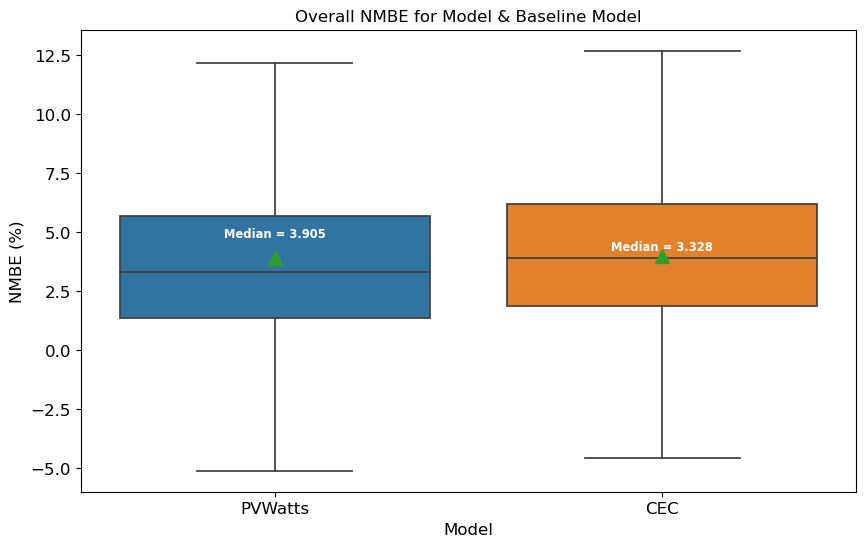

In [27]:
nbe = []
pvw = 100 * ((df['Baseline Model Power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])).to_frame()
pvw.rename(columns = {0 : 'NBE'}, inplace = True)
pvw['Model'] = 'PVWatts'
nbe.append(pvw)
test =  100 * ((df['Modeled DC power'] - df['Measured DC power (W)'])/(df['Measured DC power (W)'])).to_frame()
test.rename(columns = {0 : 'NBE'}, inplace = True)
test['Model'] = model_name
nbe.append(test)
nbe_df = pd.concat(nbe, ignore_index=True)
box_plot = sns.boxplot(x='Model', y='NBE', data=nbe_df, showfliers=False, showmeans=True, meanprops={'markersize':10})
plt.ylabel('NMBE (%)')
medians = nbe_df.groupby(['Model'])['NBE'].median()
vertical_offset = nbe_df['NBE'].median() * 0.25 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,('Median = '+str(round(medians[xtick],3))),horizontalalignment='center',size='x-small',color='w',weight='semibold')
plt.title('Overall NMBE for Model & Baseline Model')

Text(0.5, 1.0, 'ECDF of Model and Baseline Model Residuals')

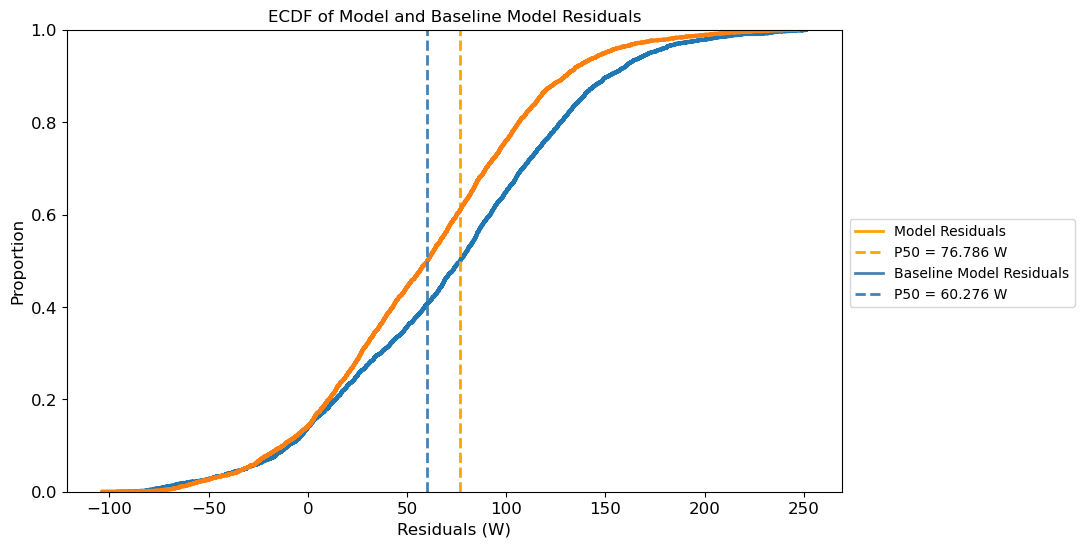

In [28]:
#ecdf of the two models overlayed & p50 given
sns.ecdfplot(data=df, x='Residuals', linewidth=3)
plt.vlines(x=np.percentile(df['Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='orange',linestyles='dashed')
sns.ecdfplot(data=df, x='Baseline Residuals',linewidth=3)
plt.vlines(x=np.percentile(df['Baseline Residuals'].dropna(), 50), ymin=0, ymax=1, linewidth=2, color='steelblue',linestyles='dashed')


plt.xlabel('Residuals (W)')
line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Model Residuals')
line_2 = Line2D([0], [0], color='orange', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Residuals'].dropna(), 50),3))+' W'))
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model Residuals')
line_4 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='--',label=('P50 ='+' '+str(round(np.percentile(df['Baseline Residuals'].dropna(), 50),3))+' W'))

lines = [line_1,line_2,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.01, 0.4],handles=lines)
plt.title('ECDF of Model and Baseline Model Residuals')

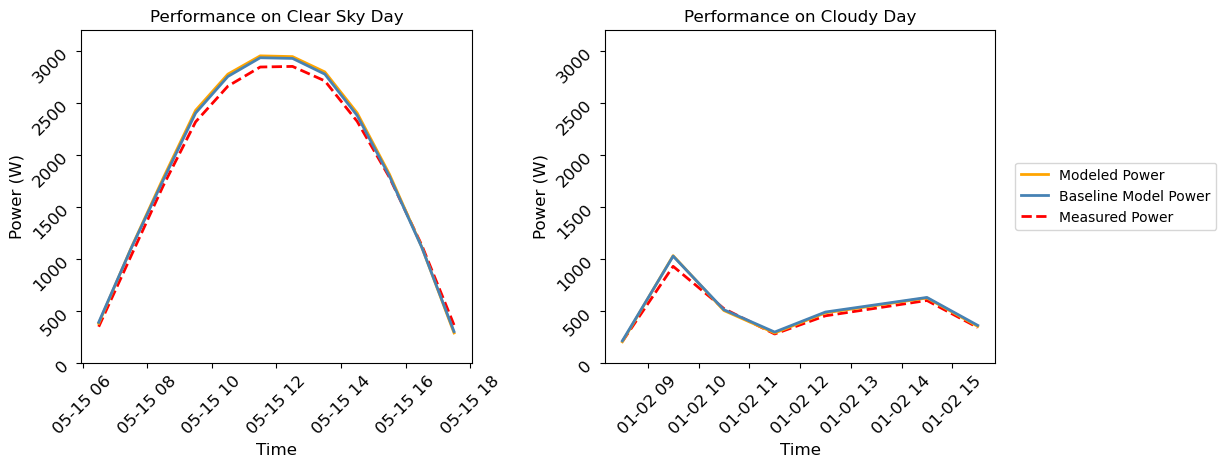

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.tight_layout(w_pad = 5)

#diurnal plot for clearsky
day = 15
month = 5
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured DC power (W)'], linewidth=2, linestyle = 'dashed',color='red', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'], linewidth=2, color='orange', zorder=5.5)
ax1.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Baseline Model Power'], linewidth=2, color='steelblue', zorder=5.5)
ax1.tick_params(labelrotation = 45)
ax1.set_ylabel('Power (W)')
ax1.set_xlabel('Time')
ax1.set_ylim(0,3200)
plt.grid(False)
ax1.patch.set_visible(False)
ax1.set_title('Performance on Clear Sky Day')


#diurnal plot for cloudy day
day = 2
month = 1
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Measured DC power (W)'], linewidth=2, linestyle = 'dashed', color='red', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Modeled DC power'], linewidth=2, color='orange', zorder=5.5)
ax2.plot(df[(df.index.month == month) & (df.index.day == day)].index,
     df[(df.index.month == month) & (df.index.day == day)]['Baseline Model Power'], linewidth=2, color='steelblue', zorder=5.5)
ax2.tick_params(labelrotation = 45)
ax2.set_ylabel('Power (W)')
ax2.set_xlabel('Time')
ax2.set_ylim(0,3200)
plt.grid(False)
ax2.patch.set_visible(False)
ax2.set_title('Performance on Cloudy Day')

line_1 = Line2D([0], [0], color='orange', linewidth=2, linestyle='-',label='Modeled Power')
line_3 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label='Baseline Model Power')
line_4 = Line2D([0], [0], color='red', linewidth=2, linestyle='--',label='Measured Power')
lines = [line_1,line_3,line_4]
plt.legend(prop=dict(size='small'), loc=[1.05, 0.4],handles=lines)



Text(0.5, 1.0, 'NMBE (%) of models in different irradiance bins')

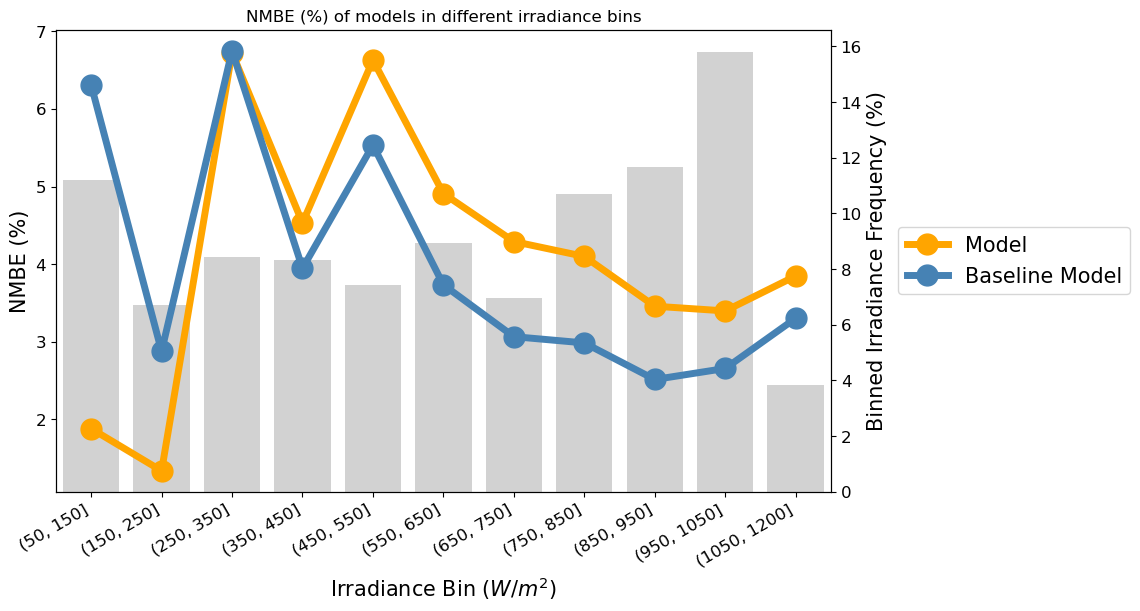

In [31]:
bins = df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins.rename(columns = {'Irradiance Bins' : 'Frequency'}, inplace = True)
bins['Irradiance Bins'] = bins.index
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
y = df.groupby('Irradiance Bins').mean()['NBE']
ax.plot(x, y, 'orange', marker='o', zorder=6.5, linewidth=5, markersize=15)
y = df.groupby('Irradiance Bins').mean()['Baseline NBE']
ax.plot(x, y, 'steelblue', marker='o', zorder=6.5, linewidth=5, markersize=15)
plt.xticks(rotation=30, ha='right')

ax.set_ylabel('NMBE (%)', fontsize=15)
ax.set_xlabel('Irradiance Bin ($W/m^2$)', fontsize=15)
#ax.set_title(system+ ' System')
ax.legend(['Model','Baseline Model'],loc='center right',bbox_to_anchor=(1.4, 0.5), fontsize=15)
#ax.set_ylim(-5,10)


ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, ci=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
plt.title('NMBE (%) of models in different irradiance bins')